# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [68]:
df = pd.read_csv("data/NewsAggregatorDataset/newsCorpora.csv", sep="\t",header=None)
feature = ["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"]
df.columns = feature
pub = ["Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
# 記事の抽出
df = df[df.PUBLISHER.isin(pub)]

df_target = df.loc[:,["TITLE", "CATEGORY"]]
test, train = train_test_split(df_target, test_size=0.8, shuffle=True, stratify=df_target.CATEGORY, random_state=20)
test, valid = train_test_split(test, test_size=0.5, shuffle=True, stratify=test.CATEGORY, random_state=20)

In [71]:
train.CATEGORY.value_counts()

e    4076
b    1976
t     919
m     580
Name: CATEGORY, dtype: int64

In [72]:
valid.CATEGORY.value_counts()

e    510
b    247
t    115
m     72
Name: CATEGORY, dtype: int64

In [73]:
test.CATEGORY.value_counts()

e    509
b    247
t    114
m     73
Name: CATEGORY, dtype: int64

In [74]:
train.to_csv("data/train.txt",sep="\t",header=None,index=None)
test.to_csv("data/test.txt",sep="\t",header=None,index=None)
valid.to_csv("data/valid.txt",sep="\t",header=None,index=None)

## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
import joblib

In [101]:
X_train = pd.read_table("data/train.txt", header=None)
X_valid = pd.read_table("data/valid.txt", header=None)
X_test = pd.read_table("data/test.txt", header=None)
Column = ["TITLE", "CATEGORY"]
X_train.columns = Column
X_valid.columns = Column
X_test.columns = Column
X_train["TMP"] = "train"
X_valid["TMP"] = "valid"
X_test["TMP"] = "test"

# 特徴抽出を一括する
data = pd.concat([X_train, X_valid, X_test]).reset_index(drop=True)

# 一文字の単語を省かないためのpattern
vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
bag = vectorizer.fit_transform(data["TITLE"])

# toarrayで特徴量ベクトルに変換(出現頻度)
data = pd.concat([data, pd.DataFrame(bag.toarray())], axis=1)

# 保存
joblib.dump(vectorizer.vocabulary_, "data/vocabulary")

# TMPが~の部分を抜き出して余計なものを排除してから保存
X_train = data.query('TMP=="train"').drop(Column + ["TMP"], axis=1)
X_valid = data.query('TMP=="valid"').drop(Column + ["TMP"], axis=1)
X_test = data.query('TMP=="test"').drop(Column + ["TMP"], axis=1)

X_train.to_csv("data/train.feature.txt", sep="\t", index=False, header=None)
X_valid.to_csv("data/valid.feature.txt", sep="\t", index=False, header=None)
X_test.to_csv("data/test.feature.txt", sep="\t", index=False, header=None)

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [128]:
from sklearn.linear_model import LogisticRegression

In [129]:
X_train = pd.read_table("data/train.feature.txt", header=None)
Y_train = pd.read_table("data/train.txt", header=None)[1] # CATEGORYの行

# penaltyは過学習を防ぐためのもの l1, l2など default l2
# l1はデータの特徴量を削減して識別境界線の一般化を図る
# l2はデータ全体の重みを減少させることで識別境界線の一般化を図る

# solver
"""
'newton-cg'、'lbfgs'、'liblinear'、'sag'、'saga'のうちから選択される。
デフォルトは'lbfgs'。小さなデータセットには'liblnear'が適し、大きなデータセットに対しては'sag'、'saga'の計算が速い。
複数クラスの問題には、'newton-cg'、'sag'、'saga'、'lbfgs'が対応し、'liblinear'は一対他しか対応しない。
その他ノルムの種類とソルバーの対応。
"""

classifier = LogisticRegression(penalty="l2", solver="sag", random_state=20, max_iter=1000)
classifier.fit(X_train, Y_train)
joblib.dump(classifier, "data/model.joblib")

['data/model.joblib']

In [130]:
classifier.score(X_train, Y_train)

0.9957621507085155

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [131]:
def prop(X_test):
    Y_test = classifier.predict(X_test)
    return Y_test

X_test = pd.read_table("data/test.feature.txt", header=None)
Y_test = prop(X_test)

## 54. 正解率の計測
2で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [132]:
from sklearn.metrics import accuracy_score

X_train = pd.read_table("data/train.feature.txt", header=None)
X_test = pd.read_table("data/test.feature.txt", header=None)
Y_train = pd.read_table("data/train.txt", header=None)[1]
Y_test = pd.read_table("data/test.txt", header=None)[1]

print("train acc: {}".format(accuracy_score(Y_train, classifier.predict(X_train))))
print("test acc: {}".format(accuracy_score(Y_test, classifier.predict(X_test))))

train acc: 0.9957621507085155
test acc: 0.8918345705196182


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [133]:
from sklearn.metrics import confusion_matrix

print("train confusion matrix:\n {}".format(confusion_matrix(Y_train, classifier.predict(X_train))))
print("test confusion matrix:\n {}".format(confusion_matrix(Y_test, classifier.predict(X_test))))

train confusion matrix:
 [[1970    2    0    4]
 [   1 4074    0    1]
 [   1    4  575    0]
 [   9   10    0  900]]
test confusion matrix:
 [[215  23   2   7]
 [  7 499   2   1]
 [  7  14  48   4]
 [ 18  15   2  79]]


## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [134]:
from sklearn.metrics import recall_score, precision_score, f1_score

Y_pred = classifier.predict(X_test)

print("test recall of None: {}".format(recall_score(Y_test, Y_pred, average=None)))
print("test recall of micro: {}".format(recall_score(Y_test, Y_pred, average="micro")))
print("test recall of macro: {}".format(recall_score(Y_test, Y_pred, average="macro")))
print("test precision of None: {}".format(precision_score(Y_test, Y_pred, average=None)))
print("test precision of micro: {}".format(precision_score(Y_test, Y_pred, average="micro")))
print("test precision of macro: {}".format(precision_score(Y_test, Y_pred, average="macro")))
print("test f1 of None: {}".format(f1_score(Y_test, Y_pred, average=None)))
print("test f1 of micro: {}".format(f1_score(Y_test, Y_pred, average="micro")))
print("test f1 of macro: {}".format(f1_score(Y_test, Y_pred, average="macro")))

test recall of None: [0.87044534 0.98035363 0.65753425 0.69298246]
test recall of micro: 0.8918345705196182
test recall of macro: 0.8003289203557128
test precision of None: [0.87044534 0.90562613 0.88888889 0.86813187]
test precision of micro: 0.8918345705196182
test precision of macro: 0.8832730588628955
test f1 of None: [0.87044534 0.94150943 0.75590551 0.77073171]
test f1 of micro: 0.8918345705196182
test f1 of macro: 0.8346479993049789


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [136]:
vocabulary_ = vectorizer.vocabulary_
coefs = classifier.coef_

for i in coefs:
    d = dict(zip(vocabulary_, i))
    d_top = sorted(d.items(), key=lambda x: abs(x[1]), reverse=True)[:10] # 二番目の重みでsort
    print(d_top)
    print()
    d_bottom = sorted(d.items(), key=lambda x: abs(x[1]), reverse=False)[:10]
    print(d_bottom)
    print()

[('loved', 1.8337184688620582), ('disks', 1.7255013113238236), ('declining', 1.5917311907552358), ('mountains', 1.511455451575293), ('healthy', 1.4433241427194738), ('increase', 1.418420108038275), ('intergalactic', 1.3655449331965839), ('expecting', 1.3018426391395137), ('accompany', 1.2716661944012129), ('poll', 1.237041993279768)]

[('to', 0.0), ('krona', 0.0), ('are', 0.0), ('develop', 0.0), ('newly', 0.0), ('but', 0.0), ('related', 0.0), ('asiana', 0.0), ('vs', 0.0), ('sisters', 0.0)]

[('witherspoon', -1.662994035512385), ('txu', 1.5526849430111505), ('oreal', 1.4992508359363288), ('beautiful', 1.4861757791150643), ('earner', 1.4431275677560158), ('mountain', 1.4190613089141983), ('healthy', -1.308345649918812), ('slimming', 1.2839271809983), ('unilever', -1.2610354055031692), ('literally', -1.2099611686321985)]

[('to', 0.0), ('krona', 0.0), ('are', 0.0), ('develop', 0.0), ('newly', 0.0), ('but', 0.0), ('related', 0.0), ('asiana', 0.0), ('vs', 0.0), ('sisters', 0.0)]

[('separat

## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [ ]:
# Cパラメータ: モデルが学習する識別境界線が教師データの分類間違いに対してどれくらい厳しくするのかという指標 default:1.0

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X_train = pd.read_table("data/train.feature.txt", header=None)
X_test = pd.read_table("data/test.feature.txt", header=None)
X_valid = pd.read_table("data/valid.feature.txt", header=None)
Y_train = pd.read_table("data/train.txt", header=None)[1]
Y_test = pd.read_table("data/test.txt", header=None)[1]
Y_valid = pd.read_table("data/valid.txt", header=None)[1]

C_list = [0.1, 1.0, 10, 100]
train_acc = []
valid_acc = []
test_acc = []

for c in C_list:
    classifier = LogisticRegression(penalty="l2", solver="sag", random_state=20, C=c)
    classifier.fit(X_train, Y_train)
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    valid_acc.append(accuracy_score(Y_valid, classifier.predict(X_valid)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))

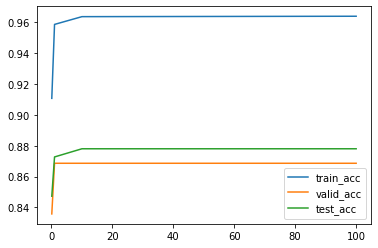

In [120]:
plt.plot(C_list, train_acc, label="train_acc")
plt.plot(C_list, valid_acc, label="valid_acc")
plt.plot(C_list, test_acc, label="test_acc")
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [123]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [124]:
# test_accは58のものが最初から入ってる

# max_depth木の深さ default:None 伸び放題
max_depth_list = [2, 4, 8, 16]
for m in max_depth_list:
    classifier = RFC(max_depth=m, random_state=20)
    classifier.fit(X_train, Y_train)
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))
    
best_index = test_acc.index(max(test_acc))
if best_index < 4:
    BestAlgorithm = "LR"
    BestParam = "C={}".format(C_list[best_index])
else:
    BestAlgorithm = "RFC"
    BestParam = "C={}".format(C_list[best_index])
    
print(BestAlgorithm, BestParam)

LR C=10


In [125]:
print(accuracy_score(Y_test, classifier.predict(X_test)))

0.5853658536585366


In [126]:
max(test_acc)

0.8780487804878049